In [41]:
import matplotlib.pyplot as plt
import pandas as pd
import math
import seaborn as sns
import matplotlib as mpl
import numpy as np

In [24]:
def calculate_statistics(sequences):
    num_sequences = len(sequences)
    avg_length = int(sum(len(seq) for seq in sequences) / num_sequences) # if isinstance(seq, str)
    min_length = min(len(seq) for seq in sequences)
    max_length = max(len(seq) for seq in sequences)

    return {
        "Number of sequences": num_sequences,
        "Average sequence length": avg_length,
        "Min sequence length": min_length,
        "Max sequence length": max_length
    }

### create pre-mirna feature for mirgene data


In [9]:
def remove_pre_lower_45(data, name):
    pre_len = data.apply(lambda row: len(row['pre_mirna']), axis=1)
    below_threshold = sum(pre < 45 for pre in pre_len)
    rows_below_threshold = pre_len < 45
    data = data[~rows_below_threshold]
    return data, rows_below_threshold

def remove_negatives(data, name):
    df_numeric = data.applymap(pd.to_numeric, errors='coerce')
    # Identify rows where any column contains negative values
    negative_rows = (df_numeric < 0).any(axis=1)
    # Remove rows with negative values
    df_cleaned = data[~negative_rows]
    return df_cleaned, negative_rows

def remove_flanks(full_seq, flank1, flank2):
    result = full_seq.replace(flank1, "").replace(flank2, "")
    return result

In [11]:
mirgene_data = pd.read_csv('/sise/vaksler-group/IsanaRNA/Transformers/Rom/Data_output/miRGeneDB_output/miRGeneDB_features.csv')
mirgene_data = mirgene_data.dropna(subset=['flank1', 'flank2'])
mirgene_data['pre_mirna'] = mirgene_data.apply(lambda row: remove_flanks(row['full_seq'], row['flank1'], row['flank2']), axis=1)
mirgene_data, rows_negative_m = remove_negatives(mirgene_data, "mirgene")
mirgene_data, rows_below_threshold_m = remove_pre_lower_45(mirgene_data, "mirgene ")

human_data = pd.read_csv('/sise/vaksler-group/IsanaRNA/Transformers/GPT_env/human_data_with_premirna_mers.csv')
human_data, rows_negative_h = remove_negatives(human_data, "human ")
human_data, rows_below_threshold_h= remove_pre_lower_45(human_data, "human ")
mirgene_data.to_csv("/sise/vaksler-group/IsanaRNA/Transformers/GPT_env/mirgene_data_premirna.csv")
human_data.to_csv('/sise/vaksler-group/IsanaRNA/Transformers/GPT_env/human_data_premirna.csv')

/tmp/ipykernel_1237/3868619751.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_numeric = data.applymap(pd.to_numeric, errors='coerce')
/tmp/ipykernel_1237/3868619751.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_numeric = data.applymap(pd.to_numeric, errors='coerce')


In [70]:
gff_data = pd.read_csv('/sise/vaksler-group/IsanaRNA/Transformers/GPT_env/bastian_data_after_filters_with_star_code_3.csv')
mirgene_data = pd.read_csv('/sise/vaksler-group/IsanaRNA/Transformers/GPT_env/mirgene_data_premirna.csv')
human_data = pd.read_csv('/sise/vaksler-group/IsanaRNA/Transformers/GPT_env/human_data_premirna.csv')

In [71]:
gff_data['pre_mirna'] = gff_data['Hairpin_seq_trimmed']

In [72]:
human_data['Star_start'] = human_data['Start_star']
mirgene_data['Star_start'] = mirgene_data['Start_star']
gff_data['Star_start'] = gff_data['Start_star']

human_data['Mature_start'] = human_data.apply(lambda row: row['full_seq'].find(row['Mature']), axis=1)
mirgene_data['Mature_start'] = mirgene_data.apply(lambda row: row['full_seq'].find(row['Mature']), axis=1)

human_data['Mature_end'] = human_data.apply(lambda row: row['Mature_start']+len(row['Mature'])-1, axis=1)
mirgene_data['Mature_end'] = mirgene_data.apply(lambda row: row['Mature_start']+len(row['Mature'])-1, axis=1)


In [73]:
gff_data['data'] = 'MirMachine'
mirgene_data['data'] = 'MirGeneDB'
human_data['data'] = 'Human'
human_data['prime'] = human_data.apply(lambda row: '5p' if row['Mature_start'] < row['Star_start'] else '3p', axis=1)
mirgene_data['prime'] = mirgene_data.apply(lambda row: '5p' if row['Mature_start'] < row['Star_start'] else '3p', axis=1)
gff_data['prime'] = gff_data.apply(lambda row: '5p' if row['Mature_start'] < row['Star_start'] else '3p', axis=1)

In [77]:
all_data = pd.concat([human_data, mirgene_data, gff_data], join='inner', ignore_index=True)

In [78]:
all_data = all_data[all_data['pre_mirna'].apply(len) <= 65]

In [79]:
before_len = len(all_data)
print("len all data: ", before_len)
all_data_full = all_data.drop_duplicates(subset='full_seq', keep='first')
print("len after remove dup - full seq: ")
print(len(all_data_full))
all_data = all_data.drop_duplicates(subset='pre_mirna', keep='first')
after_len = (len(all_data))
print("len after remove dup - pre_mirna: ")
print((len(all_data)))

len all data:  131965
len after remove dup - full seq: 
85132
len after remove dup - pre_mirna: 
48991


In [58]:
all_pre = all_data['pre_mirna'].to_list()

In [59]:
calculate_statistics(all_pre)

{'Number of sequences': 131965,
 'Average sequence length': 60,
 'Min sequence length': 45,
 'Max sequence length': 65}

In [15]:
all_data.to_csv("../all_data_premirna_no_dup.csv") 

In [29]:
def csv_to_fasta(csv_file, fasta_file, feature):
    df = pd.read_csv(csv_file)

    with open(fasta_file, 'w') as fasta_out:
        header_num = 0
        for index, row in df.iterrows():
            header_num += 1
            compare_seq = row[feature]
            full_seq = row['full_seq']
            data_name = row['data']
            utr = row['prime']
            fasta_out.write(f'>{header_num}|{data_name}|{utr}|{full_seq}\n{compare_seq}\n')

In [30]:
input_csv_file = '/sise/vaksler-group/IsanaRNA/Transformers/GPT_env/all_data_premirna_no_dup.csv' # no dup!!!
output_fasta_file = '/sise/vaksler-group/IsanaRNA/Transformers/GPT_env/all_data_premirna_mature_no_dup.fasta' # dup!!!
csv_to_fasta(input_csv_file, output_fasta_file, "Mature")

In [31]:
clusters_mature_files = [
    ["/sise/home/ronfay/est_all_pre_no_dup_mature80.clstr", "all80"]
]

In [32]:
# return list of lists of the content of cluster
def read_clstr_file(file_path):
    clusters = []
    with open(file_path, 'r') as file:
        current_cluster = []
        for line in file:
            if line.startswith(">Cluster"):
                if current_cluster:
                    clusters.append(current_cluster)
                # the first index of each cluster is the cluster id:
                current_cluster = [line[9:]]
            else:
                current_cluster.append(line.strip())

        if current_cluster:
            clusters.append(current_cluster)

    return clusters

def read_fasta(file_path):
    sequences = {}
    with open(file_path, 'r') as file:
        current_sequence = ""
        current_header = None
        for line in file:
            line = line.strip()
            if line.startswith('>'):
                if current_header is not None:
                    sequences[current_header] = current_sequence
                current_header = line[1:]
                current_sequence = ""
            else:
                current_sequence += line
        if current_header is not None:
            sequences[current_header] = current_sequence
    return sequences

# 4 graphs: x - cluster size, y - precentage of sequences in each cluster
def plot_cluster_diagram(size_clusters_dict, name, data_len):
    cluster_sizes = list(size_clusters_dict.keys())
    number_in_each_cluster = [(sum(size_clusters_dict[size]) / data_len) * 100 for size in cluster_sizes]

    plt.bar(cluster_sizes, number_in_each_cluster, align='center', width=1, edgecolor='blue', linewidth=1.6)
    plt.xlabel('Cluster Size')
    plt.ylabel('Percentage Of Data')
    plt.title(f'{name} - 80% mature')
    plt.ylim(0, 11)
    plt.savefig(name)
    plt.show()
                          
                                   
# one graph of the clusters with the most human seqs:
# y - size of human , size of cluster.
# x - cluster id                      
def plot_cluster_diagram_human(human_clusters, name):
   # sort by the number of human seqs in cluster
    human_clusters_sorted = sorted(human_clusters, key=lambda x: len(x[1:]), reverse=True)
    human_clusters_sorted = human_clusters_sorted[:15]
    cluster_ids = [cluster[0] for cluster in human_clusters_sorted]
    cluster_sizes = [cluster[1] for cluster in human_clusters_sorted]
    sequence_sizes = [len(cluster) - 2 for cluster in human_clusters_sorted]
    
    bar_width = 0.35
    fig, ax1 = plt.subplots()
    bar1 = ax1.bar(np.arange(len(cluster_ids)), cluster_sizes, bar_width, label='Cluster Size', color='blue')
    ax1.set_xlabel('Cluster ID', labelpad=40)
    ax1.set_ylabel('Cluster Size', color='blue')
    ax1.set_title(name)
    ax1.set_xticks(np.arange(len(cluster_ids)))
    ax1.set_xticklabels(cluster_ids)
    ax1.legend(loc='upper left')
    ax2 = ax1.twinx()
    bar2 = ax2.bar(np.arange(len(cluster_ids)) + bar_width, sequence_sizes, bar_width, label='Human Seq Count', color='orange')
    ax2.set_ylabel('Number of human seq', color='orange')
    ax2.legend(loc='upper right')
    plt.savefig(name)
    plt.show()                 

In [36]:
# returns list of lists of the seqs of specific data from each cluster
def specific_data_diagram(data_name, clusters_mature_data):
    clusters_mature_specific_data = []
    cluster_sizes = {}
    for cluster in clusters_mature_data:
        curr_cluster = []
        cluster_size = len(cluster)
        for seq in cluster:
            if data_name in seq:
                curr_cluster.append(seq)
        if curr_cluster:
            if cluster_size in cluster_sizes:
                cluster_sizes[cluster_size].append(len(curr_cluster))
            else:
                cluster_sizes[cluster_size] = [len(curr_cluster)]
            clusters_mature_specific_data.append(curr_cluster)
    return clusters_mature_specific_data, cluster_sizes

In [37]:
def create_dict_all(clusters_mature_data):
    cluster_sizes = {}
    for cluster in clusters_mature_data:
        cluster_size = len(cluster)
        if cluster_size in cluster_sizes:
            cluster_sizes[cluster_size].append(cluster_size)
        else:
            cluster_sizes[cluster_size] = [cluster_size]
    return cluster_sizes

In [38]:
# returns list of lists of human clusters where :
# the first index in every list is cluster_id and the second is cluster len
def count_human(clusters_mature_data):
    clusters_mature_human = []
    # cluster_sizes = {}
    for cluster in clusters_mature_data:
        curr_cluster = []
        for seq in cluster[1:]:
            if "Human" in seq:
                if curr_cluster==[]:
                    curr_cluster = [cluster[0], len(cluster)] # [id, cluster len, seqs...]
                curr_cluster.append(seq)
        if curr_cluster:
            clusters_mature_human.append(curr_cluster)
    return clusters_mature_human

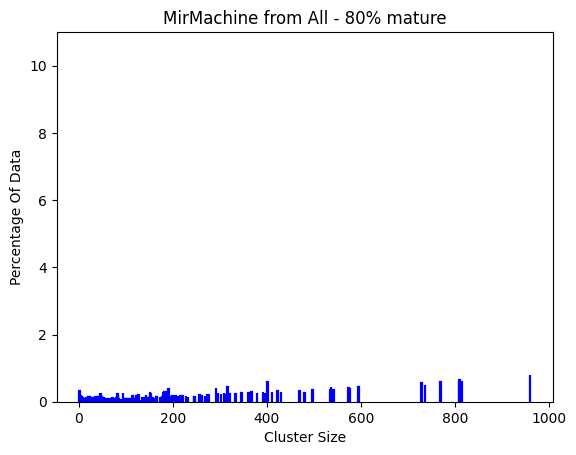

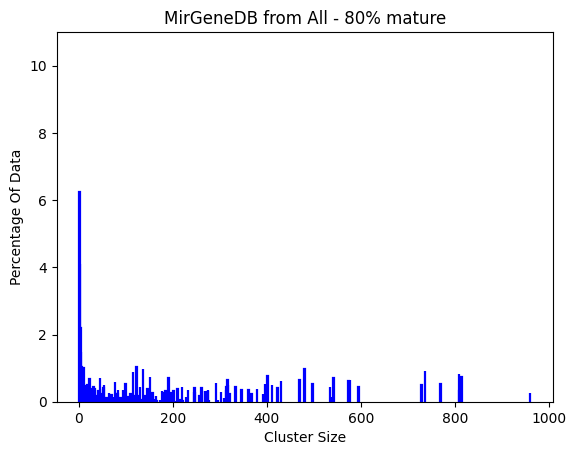

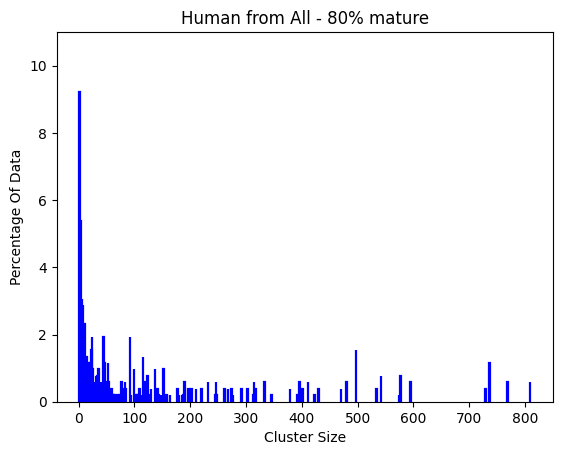

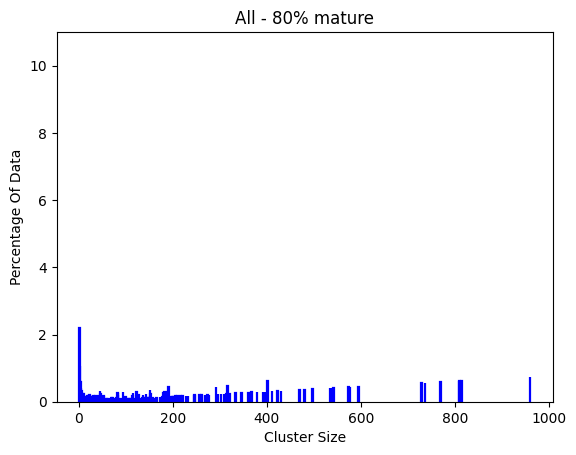

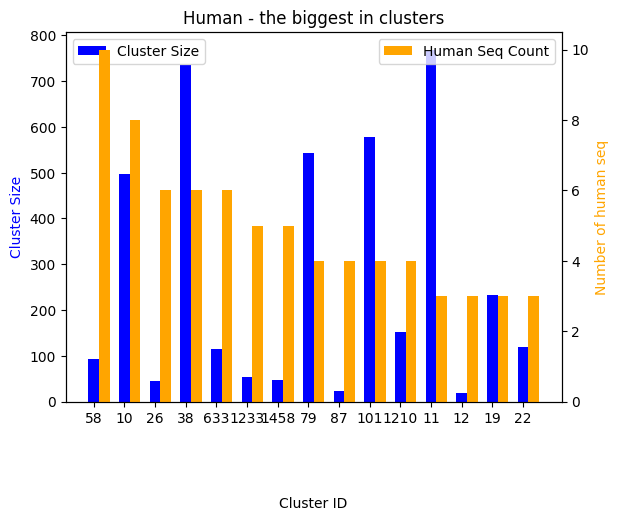

In [42]:
for index, (file_path, name) in enumerate(clusters_mature_files):  #clusters_files
    # clusters_data = read_clstr_file(file_path)
    
    # list of lists of clusters:
    clusters_mature_data = read_clstr_file(file_path)
    clusters_mature_MirMachine, size_clusters_dict_mature_MirMachine = specific_data_diagram("MirMachine", clusters_mature_data[1:])
    clusters_mature_MirGeneDB, size_clusters_dict_mature_MirGeneDB = specific_data_diagram("MirGeneDB", clusters_mature_data[1:])
    clusters_mature_Human, size_clusters_dict_mature_Human = specific_data_diagram("Human", clusters_mature_data[1:])
    size_clusters_dict_mature_all = create_dict_all(clusters_mature_data[1:])

    plot_cluster_diagram(size_clusters_dict_mature_MirMachine, "MirMachine from All", len(gff_data))
    plot_cluster_diagram(size_clusters_dict_mature_MirGeneDB, "MirGeneDB from All", len(mirgene_data))
    plot_cluster_diagram(size_clusters_dict_mature_Human, "Human from All", len(human_data))
    plot_cluster_diagram(size_clusters_dict_mature_all, "All", len(all_data))
    
    clusters_mature_only_Human = count_human(clusters_mature_data)
    plot_cluster_diagram_human(clusters_mature_only_Human, "Human - the biggest in clusters")


### test clusters

In [44]:
# define and get the clusters for the test
# this list includes only the humans in this clusters
# the first index in every list is cluster_id and the second is cluster len
human_test_clusters = [cluster for cluster in clusters_mature_only_Human if (len(cluster) >= 4 and cluster[1] < 200)]#or len(cluster)==3
human_test_clusters_alone = [cluster for cluster in clusters_mature_only_Human if len(cluster)==3]
print("Human seq in cluster length>1 :", sum([len(cluster)-2 for cluster in human_test_clusters]))
human_test_clusters = human_test_clusters[:16]
print("Human seq in cluster length>1 took to test:", sum([len(cluster)-2 for cluster in human_test_clusters]))
print("Number of human seq in cluster length=1: ", len(human_test_clusters_alone))
print("Human seq in cluster length=1 took to test :", len(human_test_clusters_alone[:49]))

# takes 51 Human seq that clusters have at least 2 of them and the cluster size<200, and 49 Human seq from clusters include only 1 seq
human_test_clusters = human_test_clusters + human_test_clusters_alone[:49]
print("Human seq in test clusters:", sum([len(cluster)-2 for cluster in human_test_clusters]))


Human seq in cluster length>1 : 138
Human seq in cluster length>1 took to test: 51
Number of human seq in cluster length=1:  265
Human seq in cluster length=1 took to test : 49
Human seq in test clusters: 100


In [45]:
# takes the clusters that were chosen to test
test_cluster_ids = [cluster[0] for cluster in human_test_clusters]
test_clusters = [cluster for cluster in clusters_mature_data if cluster[0] in test_cluster_ids]

In [46]:
# create lists of the seq ids (of the fasta file) of every data, that are in the test clusters
# '14\n', '0\t25nt, >137|Human|AAAAAATTC... *'
gff_seq_ids = []
mirgene_seq_ids = []
human_seq_ids = []
for cluster in test_clusters:
    for seq in cluster[1:]:
        start_seq = seq.find('>') + 1
        end_seq = seq.find('|')
        seq_id = seq[start_seq:end_seq]
        parts = seq.split("|")
        data_name = parts[1]
        if data_name == "Human":
            human_seq_ids.append(seq_id)
        elif data_name == "MirGeneDB":
            mirgene_seq_ids.append(seq_id)
        elif data_name == "MirMachine":
            gff_seq_ids.append(seq_id)

In [47]:
def extract_seq_from_fasta(file_path, target_ids):
    sequences = {}
    current_id = None
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('>'):
                current_id = line[1:].split('|')[0]  # Extract the ID from the header line
                if current_id in target_ids:
                    sequences[current_id] = line.strip().split('|')[-1]
            # elif current_id in target_ids:
            #     sequences[current_id] += line.strip()  # Append the sequence to the corresponding ID
    return sequences

In [48]:
fasta_path = output_fasta_file
# dicts of seq_id, full sequence:
test_human_dict_seqs = extract_seq_from_fasta(fasta_path, human_seq_ids)
test_mirgene_dict_seqs = extract_seq_from_fasta(fasta_path, mirgene_seq_ids)
test_gff_dict_seqs = extract_seq_from_fasta(fasta_path, gff_seq_ids)

In [49]:
#  Take the seq
gff_values = [value.rstrip('\n') for value in test_gff_dict_seqs.values()]
mirgene_values = [value.rstrip('\n') for value in test_mirgene_dict_seqs.values()]
human_values = [value.rstrip('\n') for value in test_human_dict_seqs.values()]

In [50]:
# Human seq for test
file_path = 'human_test_hairpin_full_seqs.txt'
with open(file_path, 'w') as file:
    # Iterate over the list and write each Human seq to the file
    for value in human_values:
        file.write(value + '\n')

In [51]:
# test_human_dict_seqs
new_gff = all_data[all_data['data']=="MirMachine"]
new_mirgene = all_data[all_data['data']=="MirGeneDB"]
new_human = all_data[all_data['data']=="Human"]
print("lens before removing test seq:")
print("len gff: ", len(new_gff))
print("len mirgene: ", len(new_mirgene))
print("len human: ", len(new_human))

train_gff = new_gff[~new_gff['full_seq'].isin(gff_values)]
train_mirgene = new_mirgene[~new_mirgene['full_seq'].isin(mirgene_values)]
train_human = new_human[~new_human['full_seq'].isin(human_values)]
print("lens after removing test seq:")
print("len(train_gff): ", len(train_gff))
print("len(train_mirgene): ", len(train_mirgene))
print("len(train_human): ", len(train_human))

test_human = new_human[new_human['full_seq'].isin(human_values)]
print("len human data in test:")
print(len(test_human))

lens before removing test seq:
len gff:  116776
len mirgene:  14700
len human:  489
lens after removing test seq:
len(train_gff):  109418
len(train_mirgene):  13444
len(train_human):  389
len human data in test:
100


In [80]:
new_gff = all_data[all_data['data']=="MirMachine"]
new_mirgene = all_data[all_data['data']=="MirGeneDB"]
new_human = all_data[all_data['data']=="Human"]

new_gff = new_gff[~new_gff['full_seq'].isin(gff_values)]
new_mirgene = new_mirgene[~new_mirgene['full_seq'].isin(mirgene_values)]
new_human = new_human[~new_human['full_seq'].isin(human_values)]

In [ ]:
new_gff.to_csv("gff_hairpin_data.csv")
new_mirgene.to_csv("mirgene_hairpin_data.csv")
new_human.to_csv("human_hairpin_data.csv")

In [ ]:
test_human.to_csv("human_test_data.csv")